In [68]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import data
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [72]:
def visualize_results(X, Y, Y_, func, special=[]):
    bbox = (np.min(X, axis=0), np.max(X, axis=0))
    xmin, ymin = bbox[0]
    xmax, ymax = bbox[1]
    
    plt.figure(figsize=(10, 10))
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])

    data.graph_surface(func, bbox)
    data.graph_data(X, Y_, Y, special=special)
    plt.show()

### 1. Generiranje linearno nerazdvojivih podataka

In [3]:
# todo: graph_surface & graph_data

In [4]:
X, Y_ = data.sample_gmm(4, 2, 30)

print(X.shape)
print(Y_.shape)

(120, 2)
(120,)


### 2. Višeslojna klasifikacija u Pythonu

In [5]:
# todo:

### 3. Linearna regresija u Tensorflowu

In [6]:
# todo: ispisati grads, izracunati grads i rucno azurirati tezine, ispisati s tf.Print

In [7]:
## 1. definicija računskog grafa
# podatci i parametri
X  = tf.placeholder(tf.float32, [None])
Y_ = tf.placeholder(tf.float32, [None])
a = tf.Variable(0.0)
b = tf.Variable(0.0)

# afini regresijski model
Y = a * X + b

# kvadratni gubitak
loss = (Y - Y_)**2

# optimizacijski postupak: gradijentni spust
trainer = tf.train.GradientDescentOptimizer(0.1)

# train_op = trainer.minimize(loss) # isto kao sljedeca dva reda
grads_and_vars = trainer.compute_gradients(loss)
train_op = trainer.apply_gradients(grads_and_vars)

## 2. inicijalizacija parametara
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## 3. učenje
# neka igre počnu!
for i in range(100):
    val_loss, _, val_a, val_b = sess.run([loss, train_op, a, b], 
        feed_dict={X: [1,2], Y_: [3,5]})
    
    if i % 10 == 0:
        print(i, val_loss, val_a, val_b)

0 [  9.  25.] 2.6 1.6
10 [ 0.00233997  0.000914  ] 1.92381 1.12335
20 [ 0.00130224  0.00049741] 1.94331 1.09172
30 [ 0.0007202   0.00027511] 1.95784 1.06821
40 [ 0.00039833  0.00015215] 1.96865 1.05073
50 [  2.20300106e-04   8.41511428e-05] 1.97669 1.03772
60 [  1.21844139e-04   4.65411758e-05] 1.98266 1.02806
70 [  6.73914328e-05   2.57360443e-05] 1.98711 1.02086
80 [  3.72703689e-05   1.42371318e-05] 1.99041 1.01552
90 [  2.06112963e-05   7.87468343e-06] 1.99287 1.01154


### 4. Logistička regresija u Tensorflowu

In [8]:
# todo: kako najbolje pazit jel float32 ili float64

In [62]:
class TFLogreg:
    def __init__(self, D, C, param_delta=0.1):
        """Arguments:
           - D: dimensions of each datapoint 
           - C: number of classes
           - param_delta: training step
        """

        # definicija podataka i parametara:
        # definirati self.X, self.Yoh_, self.W, self.b
        self.X = tf.placeholder(tf.float32, [None, D])
        self.Yoh_ = tf.placeholder(tf.float32, [None, C])
        self.W = tf.Variable(tf.random_normal([D, C]))
        self.b = tf.Variable(tf.random_normal([C]))

        # formulacija modela: izračunati self.probs
        #   koristiti: tf.matmul, tf.nn.softmax
        self.score = tf.matmul(self.X, self.W) + self.b
        self.probs = tf.nn.softmax(self.score)

        # formulacija gubitka: self.loss
        #   koristiti: tf.log, tf.reduce_sum, tf.reduce_mean
        self.loss = tf.reduce_mean(-tf.reduce_sum(self.Yoh_ * tf.log(self.probs), reduction_indices=1))
        # + param_lambda * tf.nn.l2_loss(self.W) # L2 regularizacija

        # formulacija operacije učenja: self.train_step
        #   koristiti: tf.train.GradientDescentOptimizer,
        #              tf.train.GradientDescentOptimizer.minimize
        self.trainer = tf.train.GradientDescentOptimizer(param_delta)
        self.optimizer = self.trainer.minimize(self.loss)
        
        # instanciranje izvedbenog konteksta: self.session
        #   koristiti: tf.Session
        self.session = tf.Session()

    def train(self, X, Yoh_, param_niter, verbose=False, print_every=100):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        # incijalizacija parametara
        #   koristiti: tf.initialize_all_variables
        init = tf.global_variables_initializer()

        # optimizacijska petlja
        #   koristiti: tf.Session.run
        self.session.run(init)
        
        # Training cycle
        for i in range(param_niter):
            _, val_loss = self.session.run([self.optimizer, self.loss],
                                           feed_dict={self.X: X, self.Yoh_: Yoh_})
            
            if verbose and i % print_every == 0:
                print(i, val_loss)

    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        
        return self.session.run(self.probs, feed_dict={self.X: X})
    
    def accuracy(self, X, Yoh_):
        correct_prediction = tf.equal(tf.argmax(self.probs, 1), tf.argmax(self.Yoh_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy.eval({self.X: X, self.Yoh_: Yoh_}, session=self.session)

0 0.825632
100 0.13496
200 0.127769
300 0.124067
400 0.121975
500 0.120715
600 0.119922
700 0.119405
800 0.119059
900 0.118824
Accuracy: 0.938889


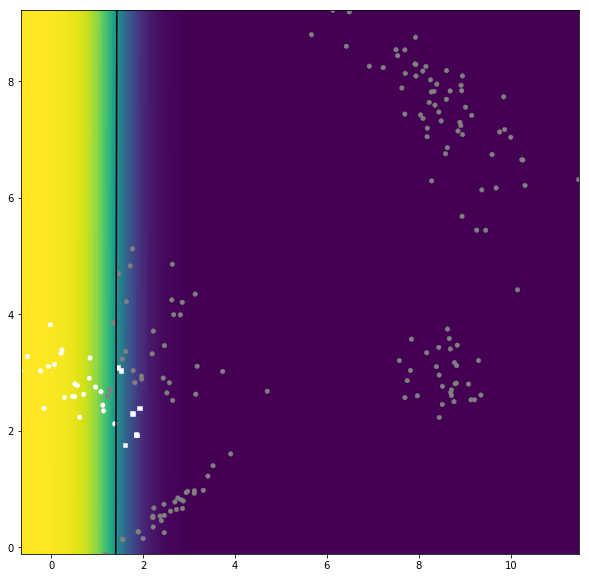

In [81]:
# inicijaliziraj generatore slučajnih brojeva
# tf.set_random_seed(100)
np.random.seed(505)

verbose = True
print_every = 100
dim = 2
K = 6
C = 2
N = 30
param_delta = 0.5
param_niter = 1000

# instanciraj podatke X i labele Yoh_
X, Y_ = data.sample_gmm(K, C, N)
Yoh_ = data.class_to_onehot(Y_)

# izgradi graf:
tflr = TFLogreg(dim, C, param_delta)

# nauči parametre:
tflr.train(X, Yoh_, param_niter, verbose, print_every)

# dohvati vjerojatnosti na skupu za učenje
probs = tflr.eval(X)
Y = probs[:,1] > 0.5

# ispiši performansu (preciznost i odziv po razredima)
# Test model
print('Accuracy:', tflr.accuracy(X, Yoh_))

# iscrtaj rezultate, decizijsku plohu
def predict_c1_class(tflr):
    def classify(X):
        return tflr.eval(X)[:,1]
    return classify

decfun = predict_c1_class(tflr)
visualize_results(X, Y, Y_, decfun)
plt.show()

### 5. Konfigurabilni duboki modeli u Tensorflowu

In [58]:
# todo: debug, simbolicka imena

In [66]:
class TFDeep:
    def __init__(self, layers, param_delta=0.1, activation=tf.nn.relu):
        self.X = tf.placeholder(tf.float32, [None, layers[0]])
        self.Yoh_ = tf.placeholder(tf.float32, [None, layers[-1]])
        self.W = []
        self.b = []
        
        prev = layers[0]
        out = self.X
        for dim in layers[1:-1]:
            temp_W = tf.Variable(tf.random_normal([prev, dim]))
            temp_b = tf.Variable(tf.random_normal([dim]))                
            self.W.append(temp_W)
            self.b.append(temp_b)
            
            out = tf.matmul(out, temp_W) + temp_b
            out = activation(out)
            
            prev = dim
        
        temp_W = tf.Variable(tf.random_normal([prev, layers[-1]]))
        temp_b = tf.Variable(tf.random_normal([layers[-1]]))
        self.W.append(temp_W)
        self.b.append(temp_b)
        
        self.probs = tf.nn.softmax(tf.matmul(out, temp_W) + temp_b)
        
        self.loss = tf.reduce_mean(-tf.reduce_sum(self.Yoh_ * tf.log(self.probs), reduction_indices=1))

        self.trainer = tf.train.GradientDescentOptimizer(param_delta)
        self.optimizer = self.trainer.minimize(self.loss)
        
        self.session = tf.Session()
    
    def train(self, X, Yoh_, param_niter, verbose=False, print_every=100):
        init = tf.global_variables_initializer()
        self.session.run(init)

        for i in range(param_niter):
            _, val_loss = self.session.run([self.optimizer, self.loss],
                                           feed_dict={self.X: X, self.Yoh_: Yoh_})
            
            if verbose and i % print_every == 0:
                print(i, val_loss)
    
    def eval(self, X):
        return self.session.run(self.probs, feed_dict={self.X: X})
    
    def accuracy(self, X, Yoh_):
        correct_prediction = tf.equal(tf.argmax(self.probs, 1), tf.argmax(self.Yoh_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy.eval({self.X: X, self.Yoh_: Yoh_}, session=self.session)

0 nan
1000 nan
2000 nan
3000 nan
4000 nan
5000 nan
6000 nan
7000 nan
8000 nan
9000 nan


C:\Users\tzadr\Anaconda2\envs\ipykernel_py3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
C:\Users\tzadr\AppData\Roaming\Python\Python36\site-packages\matplotlib\contour.py:1533: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\tzadr\AppData\Roaming\Python\Python36\site-packages\matplotlib\contour.py:1534: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\tzadr\AppData\Roaming\Python\Python36\site-packages\matplotlib\contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
C:\Users\tzadr\AppData\Roaming\Python\Python36\site-packages\matplotlib\contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
C:\Users\tzadr\AppData\Roaming\Python\Python36\site-packages\matplotlib\contour.py:1180: UserWar

Accuracy: 0.5


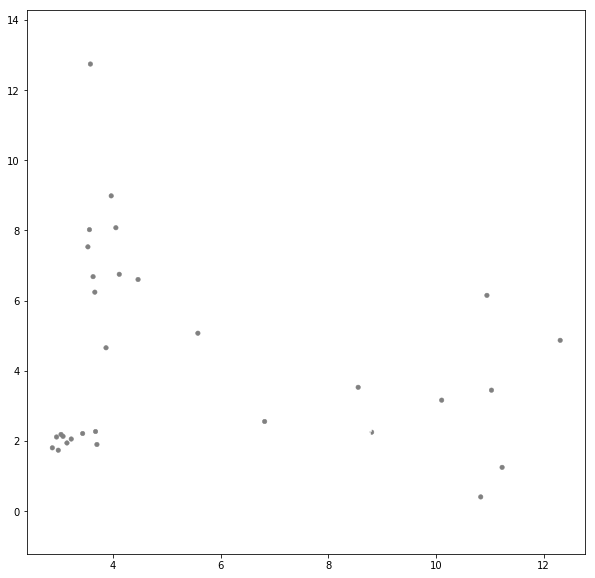

In [82]:
# np.random.seed(505)

verbose = True
print_every = 1000
dim = 2
K = 6
C = 2
N = 10
param_delta = 0.1
param_niter = 10000
layers = [dim, 10, 10, C]

X, Y_ = data.sample_gmm(K, C, N)
Yoh_ = data.class_to_onehot(Y_)

tfdeep = TFDeep(layers, param_delta)

tfdeep.train(X, Yoh_, param_niter, verbose, print_every)

probs = tfdeep.eval(X)
Y = probs[:,1] > 0.5

print('Accuracy:', tfdeep.accuracy(X, Yoh_))

# iscrtaj rezultate, decizijsku plohu
def predict_c1_class(tfdeep):
    def classify(X):
        return tfdeep.eval(X)[:,1]
    return classify

decfun = predict_c1_class(tfdeep)
visualize_results(X, Y, Y_, decfun)
plt.show()

### 6. Usporedba s jezgrenim SVM-om

In [83]:
class KSVMWrap:
    def __init__(self, X, Y_, param_svm_c=1, param_svm_gamma='auto'):
        """
            Konstruira omotač i uči RBF SVM klasifikator
            X,Y_:            podatci i točni indeksi razreda
            param_svm_c:     relativni značaj podatkovne cijene
            param_svm_gamma: širina RBF jezgre
        """
        self.model = svm.SVC(C=param_svm_c, gamma=param_svm_gamma, probability=True)
        self.model.fit(X, Y_)

    def predict(self, X):
        """
            Predviđa i vraća indekse razreda podataka X
        """
        return self.model.fit(X, Y_)

    def scores(self, X):
        """
            Vraća klasifikacijske mjere podataka X
        """
        return self.model.predict_proba(X)

    def support(self):
        """
            Indeksi podataka koji su odabrani za potporne vektore
        """
        return self.model.support_
    
    def accuracy(self, X, Y_):
        return self.model.score(X, Y_)

Accuracy: 0.95


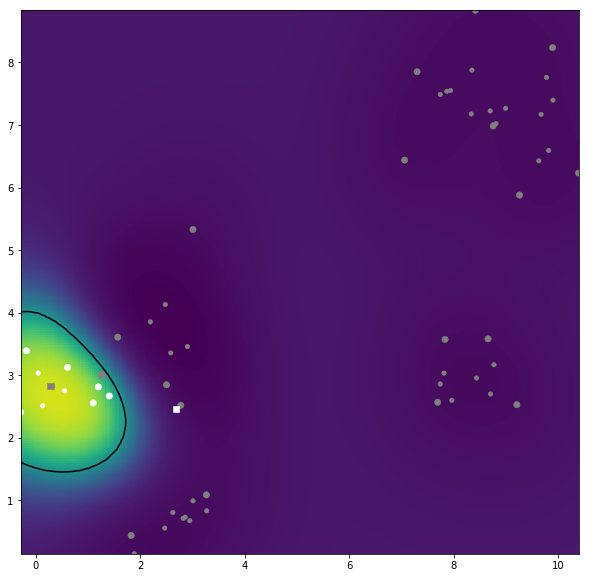

In [84]:
np.random.seed(505)

K = 6
C = 2
N = 10
param_svm_c = 1
param_svm_gamma = 'auto'

X, Y_ = data.sample_gmm(K, C, N)

svm_wrap = KSVMWrap(X, Y_, param_svm_c, param_svm_gamma)

probs = svm_wrap.scores(X)
Y = probs[:,1] > 0.5

print('Accuracy:', svm_wrap.accuracy(X, Y_))

def predict_c1_class(svm_wrap):
    def classify(X):
        return svm_wrap.scores(X)[:,1]
    return classify

decfun = predict_c1_class(svm_wrap)
visualize_results(X, Y, Y_, decfun, special=svm_wrap.support())
plt.show()

### 7. Studija slučaja: MNIST

In [85]:
from tensorflow.examples.tutorials.mnist import input_data

tf.app.flags.DEFINE_string('data_dir', 
  '/tmp/data/', 'Directory for storing data')
mnist = input_data.read_data_sets(
  tf.app.flags.FLAGS.data_dir, one_hot=True)

N = mnist.train.images.shape[0]
D = mnist.train.images.shape[1]
C = mnist.train.labels.shape[1]

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [89]:
verbose = True
print_every = 1000
param_delta = 0.1
param_niter = 10000
layers = [784, 10]

tfdeep = TFDeep(layers, param_delta)

tfdeep.train(mnist.train.images, mnist.train.labels, param_niter, verbose, print_every)

print('Accuracy:', tfdeep.accuracy(X, Yoh_))

0 14.319


KeyboardInterrupt: 

AttributeError: 'TFDeep' object has no attribute 'last_layer_w'

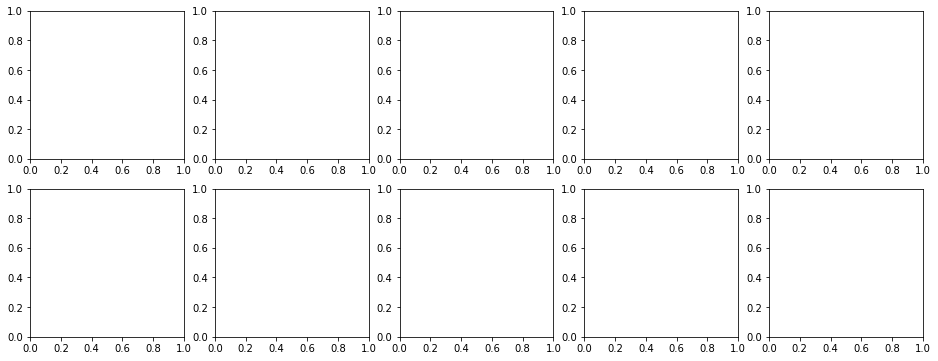

In [92]:
_, plots = plt.subplots(2, 5, figsize=(16, 6))
for i in range(10):
    vmin = tfdeep.session.run(tfdeep.last_layer_w)[:,i].min()
    vmax = tfdeep.session.run(tfdeep.last_layer_w)[:,0].max()
    plots[i].matshow(tfdeep.session.run(tfDeep.last_layer_w)[:,i].reshape(28,28),
                     cmap=plt.cm.gray, vmin=(0.5 * vmin), vmax=(0.5 * vmax))
plt.show()